In [17]:
!{sys.executable} -m pip install -v "opencv-python==4.5.1.48"
!{sys.executable} -m pip install matplotlib

Using pip 21.1.2 from d:\projects\put\computer-vision-project-2\venv\lib\site-packages\pip (python 3.7)
Non-user install because user site-packages disabled
Created temporary directory: C:\Users\aszcz\AppData\Local\Temp\pip-ephem-wheel-cache-f68m7x5l
Created temporary directory: C:\Users\aszcz\AppData\Local\Temp\pip-req-tracker-m2bajr10
Initialized build tracking at C:\Users\aszcz\AppData\Local\Temp\pip-req-tracker-m2bajr10
Created build tracker: C:\Users\aszcz\AppData\Local\Temp\pip-req-tracker-m2bajr10
Entered build tracker: C:\Users\aszcz\AppData\Local\Temp\pip-req-tracker-m2bajr10
Created temporary directory: C:\Users\aszcz\AppData\Local\Temp\pip-install-pziyw4dy
Created temporary directory: C:\Users\aszcz\AppData\Local\Temp\pip-unpack-uyh1mx8u
Removed build tracker: 'C:\\Users\\aszcz\\AppData\\Local\\Temp\\pip-req-tracker-m2bajr10'


You should consider upgrading via the 'd:\projects\put\computer-vision-project-2\venv\scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'd:\projects\put\computer-vision-project-2\venv\scripts\python.exe -m pip install --upgrade pip' command.


Load input images


In [4]:
import cv2 as cv

input_image_list = []
for i in range(1, 3):
    file_path = f'data/img_{i}.jpg'
    image = cv.imread(file_path, cv.IMREAD_GRAYSCALE)
    input_image_list.append((image, file_path))

Straighten images and remove grid lines

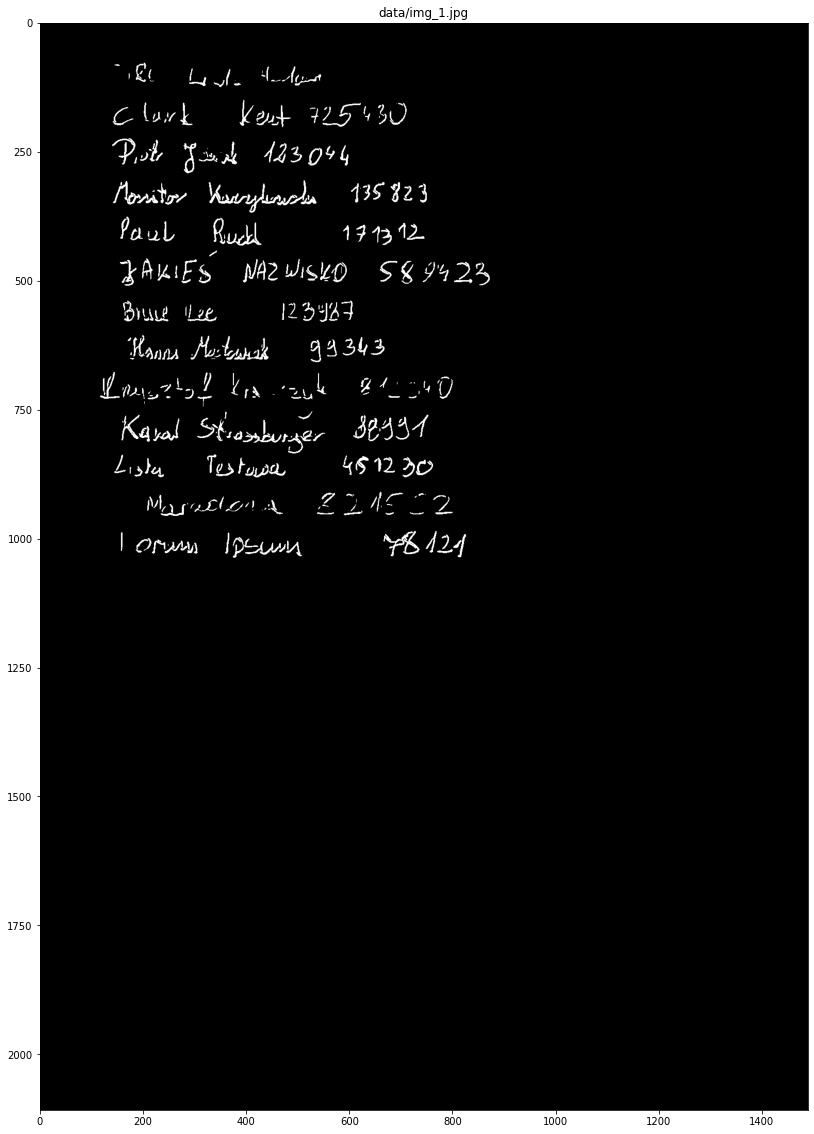

Took : 11.383s


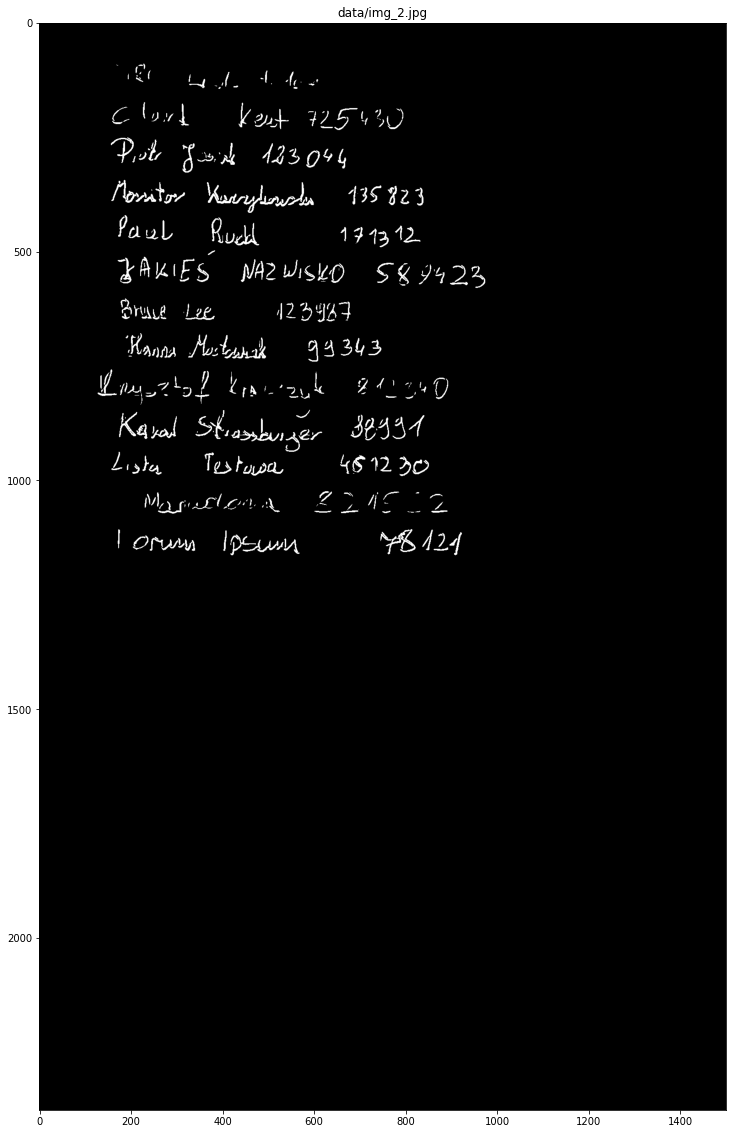

Took : 17.365s


In [5]:
from time import time

from matplotlib import pyplot as plt

from src.pipeline_functions import straighten_page, remove_grid_lines

images_list = []
image_moments = []
for image, file_path in input_image_list:
    time_start = time()
    image_straightened, moments = straighten_page(image)
    image_no_grid = remove_grid_lines(image_straightened)

    plt.figure(figsize=(20, 20))
    plt.title(file_path)
    plt.imshow(image_no_grid, cmap='gray')
    plt.show()
    duration = time() - time_start
    duration = round(duration, 3)
    print(f'Took : {duration}s')

    images_list.append(image_no_grid)
    image_moments.append(moments)

Do something

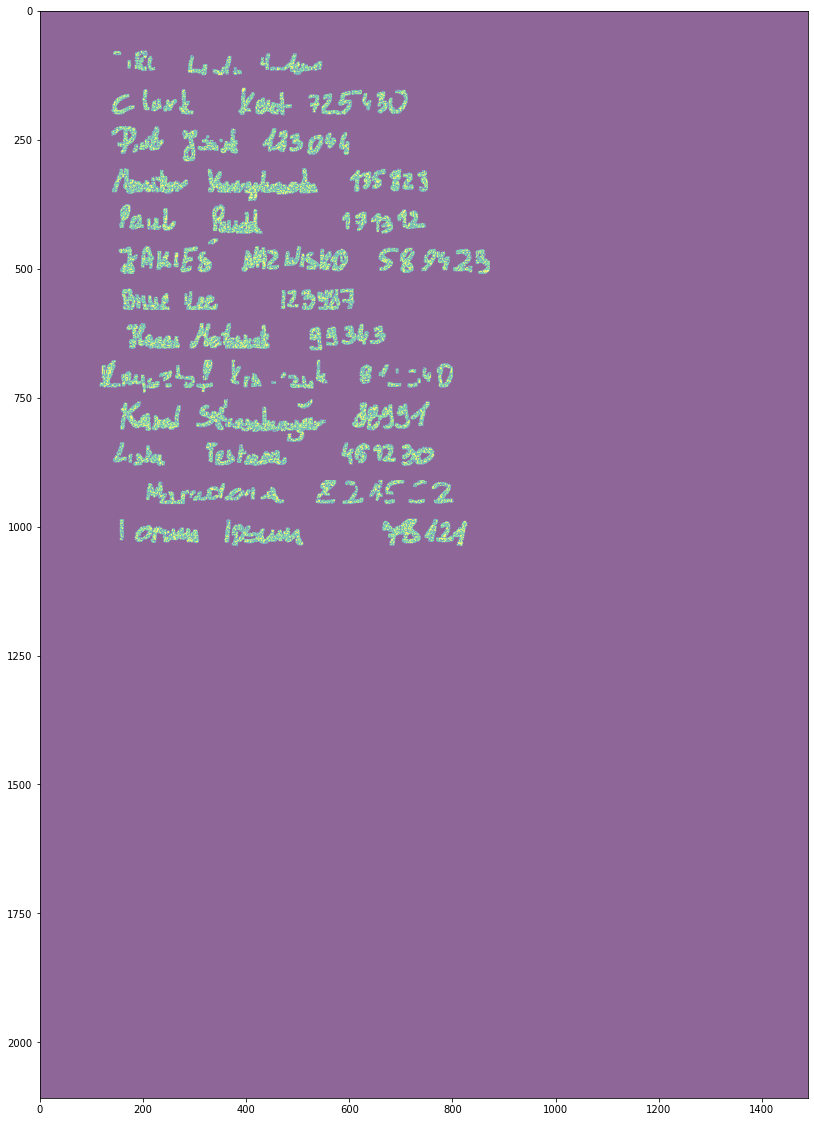

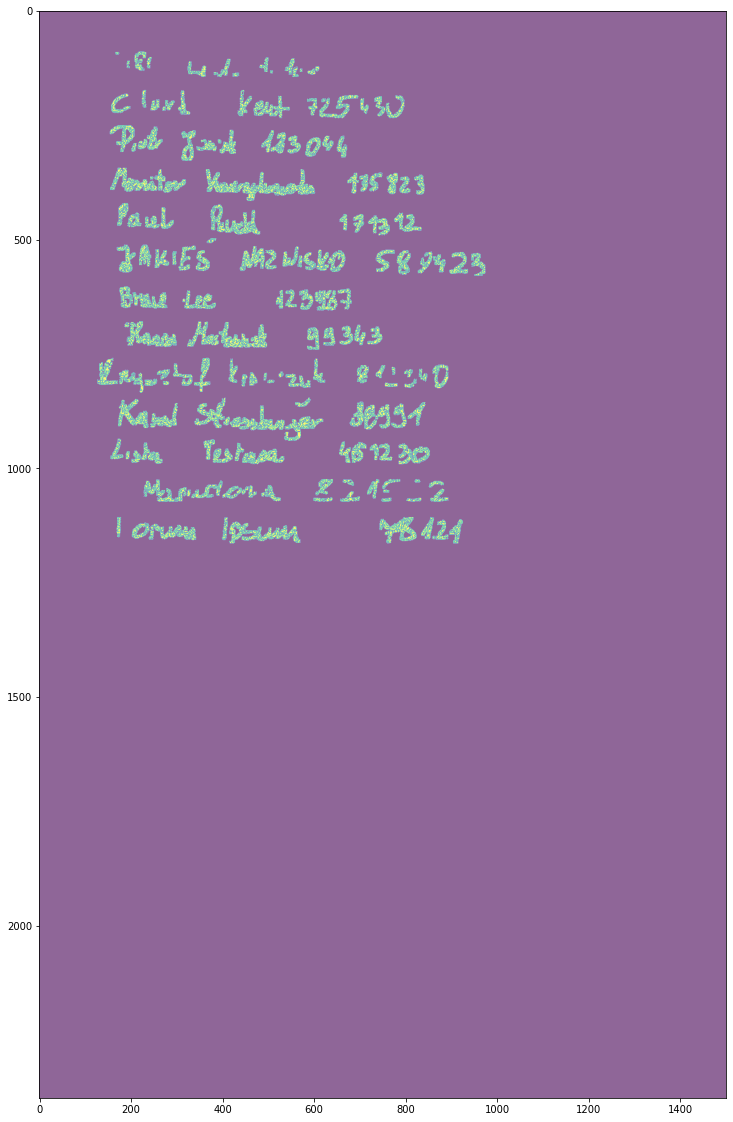

In [6]:
from skimage.morphology import square, dilation
import numpy as np
from sklearn.cluster import KMeans
from scipy import ndimage

for i, image_no_grid in enumerate(images_list):
    plt.figure(figsize=(20, 20))
    row_pixels = np.sum(image_no_grid, axis=1)
    col_pixels = np.sum(image_no_grid, axis=0)

    height, width = image_no_grid.shape
    mask_rows = np.array([[r for _ in range(width)] for r in row_pixels])
    mask_cols = np.array([col_pixels for _ in range(height)])
    mask_comp = mask_rows * mask_cols * ndimage.convolve(image_no_grid, [
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
    ])

    c = KMeans(2).fit_predict(mask_comp.reshape(-1, 1))

    mask_clusters = c.reshape(mask_comp.shape)
    mask_clusters = dilation(mask_clusters, square(1))

    plt.imshow(mask_clusters, alpha=0.6)
    plt.show()

    images_list[i] = [image_no_grid, mask_clusters]

Detect words and numbers

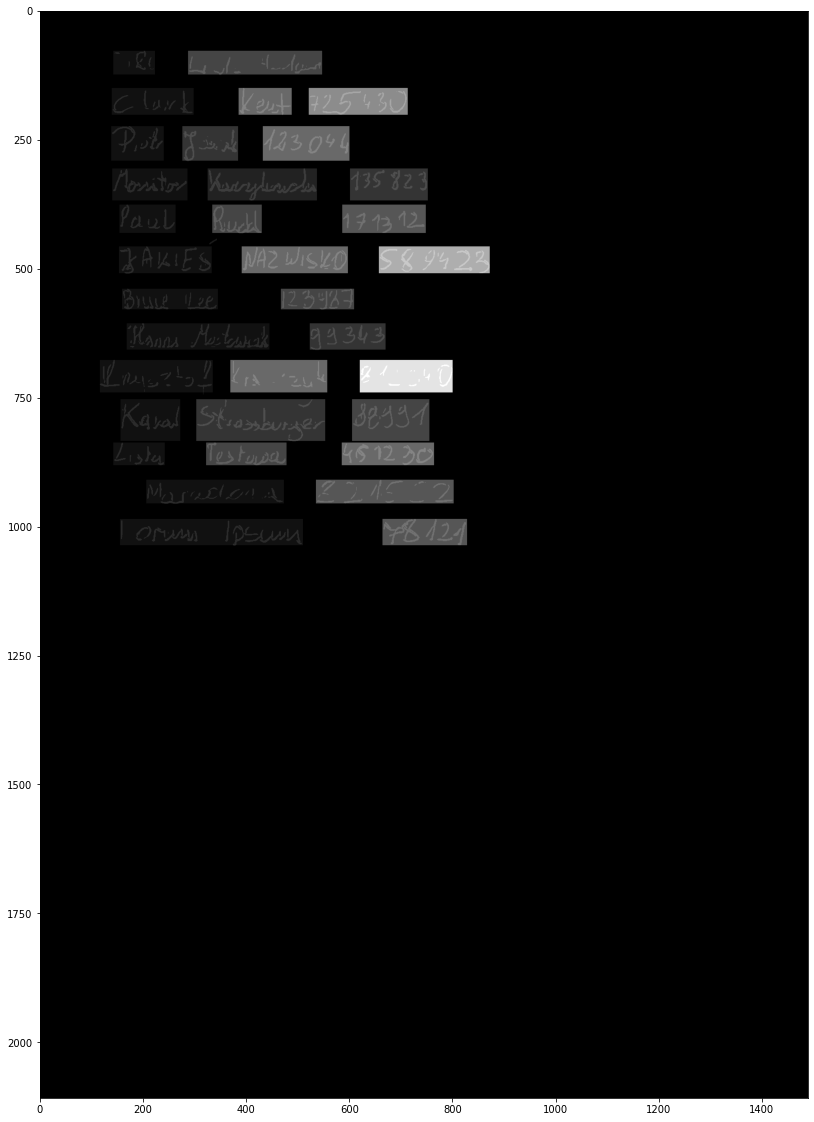

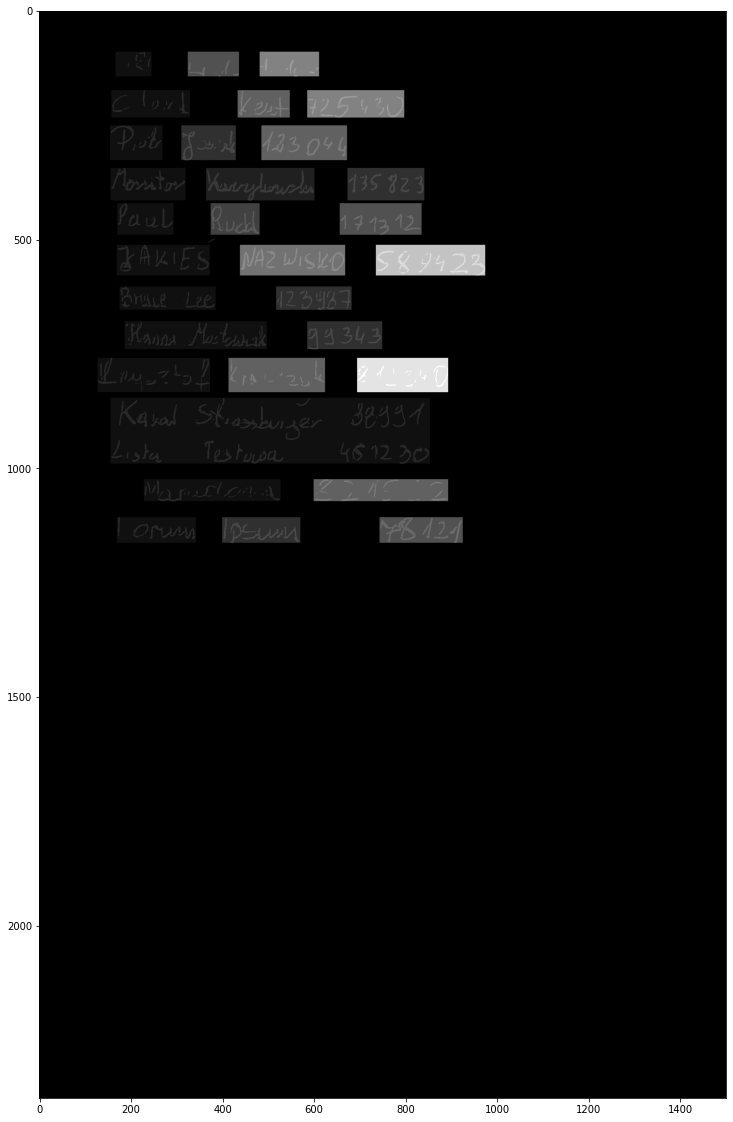

In [7]:
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity

prepared_rows_per_img = []
for (image_no_grid, mask_clusters) in images_list:
    plt.figure(figsize=(20, 20))

    background_cluster = Counter(mask_clusters.flatten()).most_common(1)[0][0]
    marker_cluster = 1 - background_cluster


    def find_groups(matrix):
        group, marked = [], []
        for num, dim in enumerate(matrix):
            if np.any(dim == marker_cluster):
                group.append(num)
            elif len(group):
                marked.append(group)
                group = []

        lines_mask = np.zeros_like(matrix)
        for i, g in enumerate(marked, 1):
            a, b = g[0], g[-1]
            lines_mask[a:b] = i

        return lines_mask, marked


    def similarity(x, y):
        if x < y:
            x, y = y, x

        sim = cosine_similarity([[x, y]], [[y, x]])
        return sim[0][0]


    rows, marked_rows = find_groups(mask_clusters)
    for g in marked_rows:
        row_segments = []

        a, b = g[0], g[-1]
        clipped = mask_clusters[a:b]
        cols, marked_cols = find_groups(clipped.T)
        if len(marked_cols):
            try:
                breaks = [(col_beg[0] - col_end[-1]) for col_end, col_beg in zip(marked_cols, marked_cols[1:])]
                max_connection_cols = np.max(breaks)
                min_connection_cols = np.min(breaks)

                for col_a, col_b in zip(marked_cols, marked_cols[1:]):
                    segments_distance = col_b[0] - col_a[-1]
                    segment_a_width = col_a[-1] - col_a[0]
                    segment_b_width = col_b[-1] - col_b[0]

                    distance_similarity_max = similarity(max_connection_cols, segments_distance)
                    distance_similarity_min = similarity(min_connection_cols, segments_distance)

                    if distance_similarity_max < 0.6 or distance_similarity_min > 0.2:
                        group_value = cols[col_a[-1] - 1][0]
                        cols[col_a[-1]:col_b[-1] + 1] = group_value

                rows[a:b] = cols.T
            except Exception as e:
                rows[a:b] = background_cluster
        else:
            rows[a:b] = background_cluster

    plt.imshow(image_no_grid, cmap='gray')
    plt.imshow(rows, alpha=0.9, cmap='gray')
    plt.show()

    prepared_rows_per_img.append({
        'img_segmented': rows,
        'background_cluster': background_cluster
    })


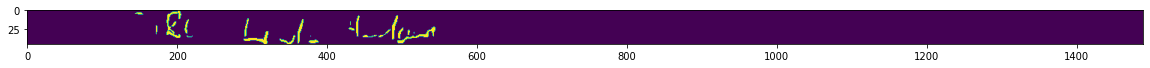

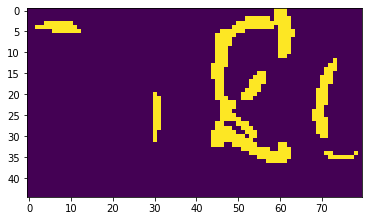

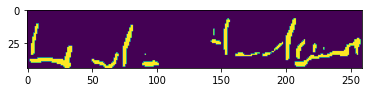

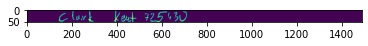

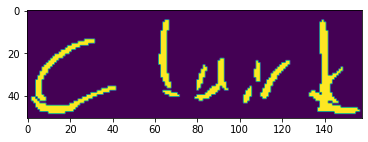

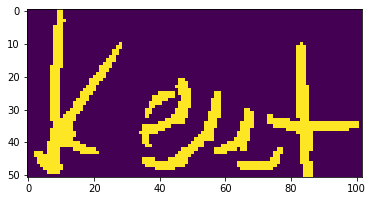

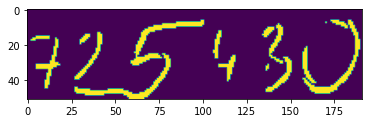

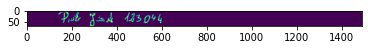

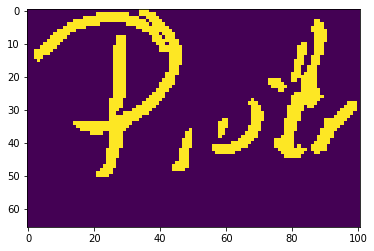

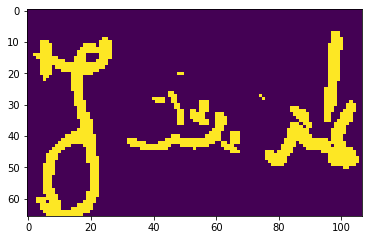

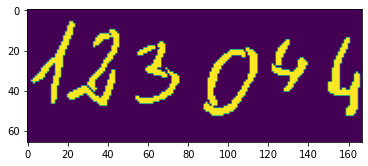

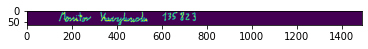

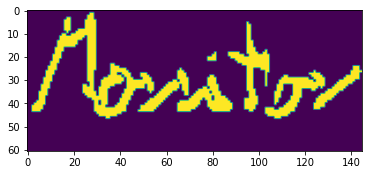

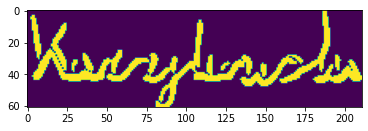

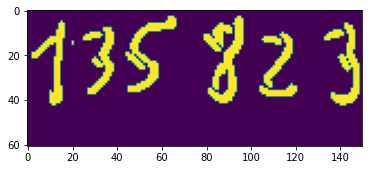

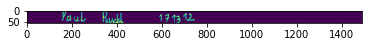

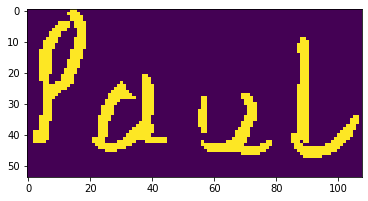

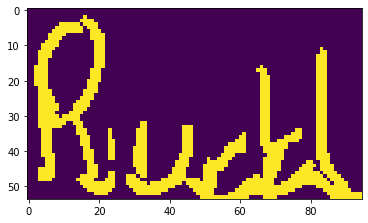

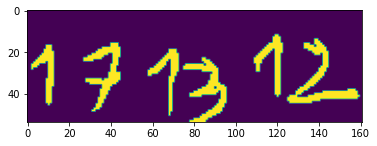

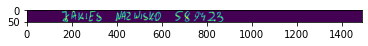

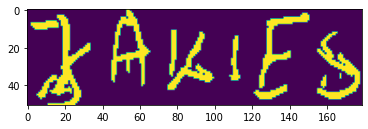

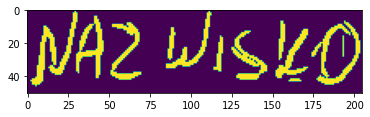

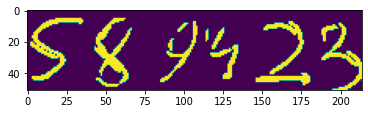

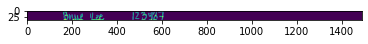

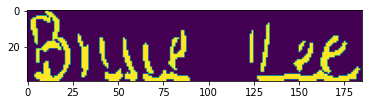

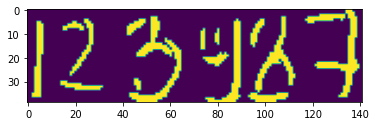

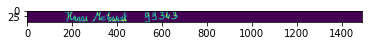

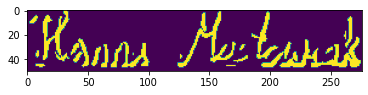

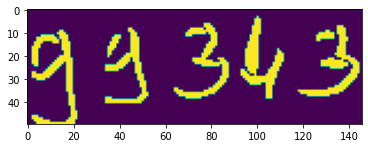

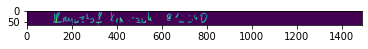

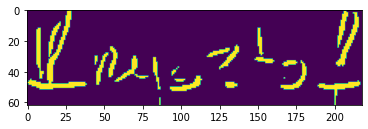

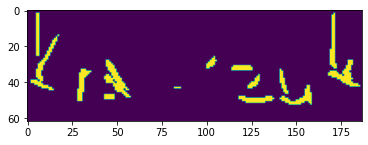

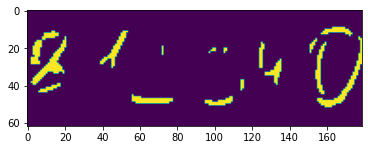

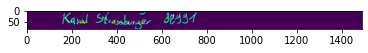

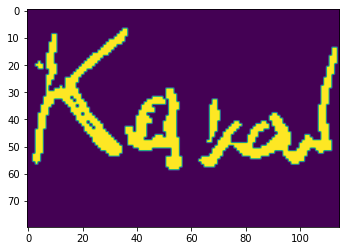

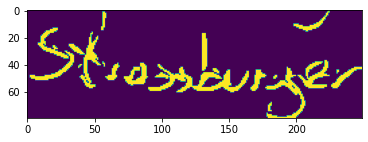

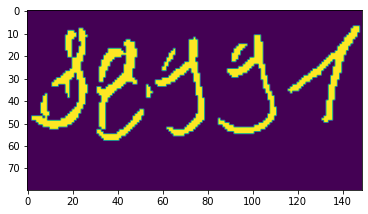

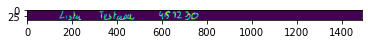

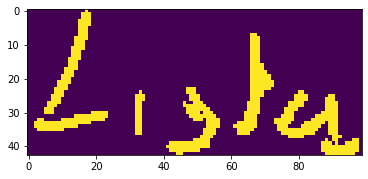

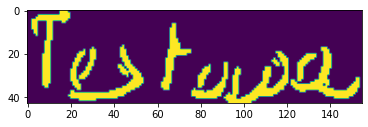

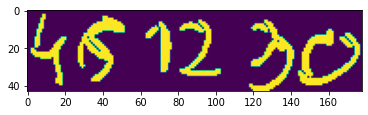

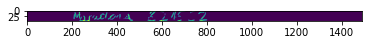

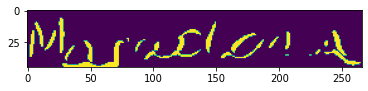

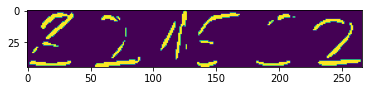

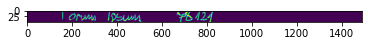

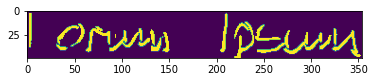

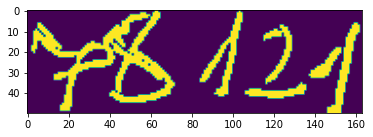

13 0


In [49]:
def extract_all_segments(img, rows_mask, background_cluster):
    # powtarzanie tego co wyzej
    def find_segments(matrix):
        group, marked = [], []
        for num, dim in enumerate(matrix):
            if np.any(dim != background_cluster):
                group.append(num)
            elif len(group):
                marked.append({
                    'data': matrix[group],
                    'from': group[0],
                    'to': group[-1]
                })
                group = []

        return marked

    all_rows = []
    rows = find_segments(rows_mask)
    for r in rows:
        cols_in_row = find_segments(r['data'].T)
        all_cols = []

        for c in cols_in_row:
            fragment = img[r['from']:r['to'], c['from']:c['to']]
            all_cols.append({
                'data': fragment,
                'from': c['from'],
                'to': c['to']
            })

        fragment = img[r['from']:r['to']]
        all_rows.append({
            'data': fragment,
            'from': r['from'],
            'to': r['to'],
            'cols': all_cols
        })

    return all_rows


plt.figure(figsize=(20, 20))

img_segmented = prepared_rows_per_img[0]['img_segmented']
background_cluster = prepared_rows_per_img[0]['background_cluster']
rows = extract_all_segments(images_list[0][0], img_segmented, background_cluster)
for r in rows:
    plt.imshow(r['data'])
    plt.show()

    for c in r['cols']:
        plt.imshow(c['data'])
        plt.show()

print(len(rows), background_cluster)


Reverse perspective transformation for mask

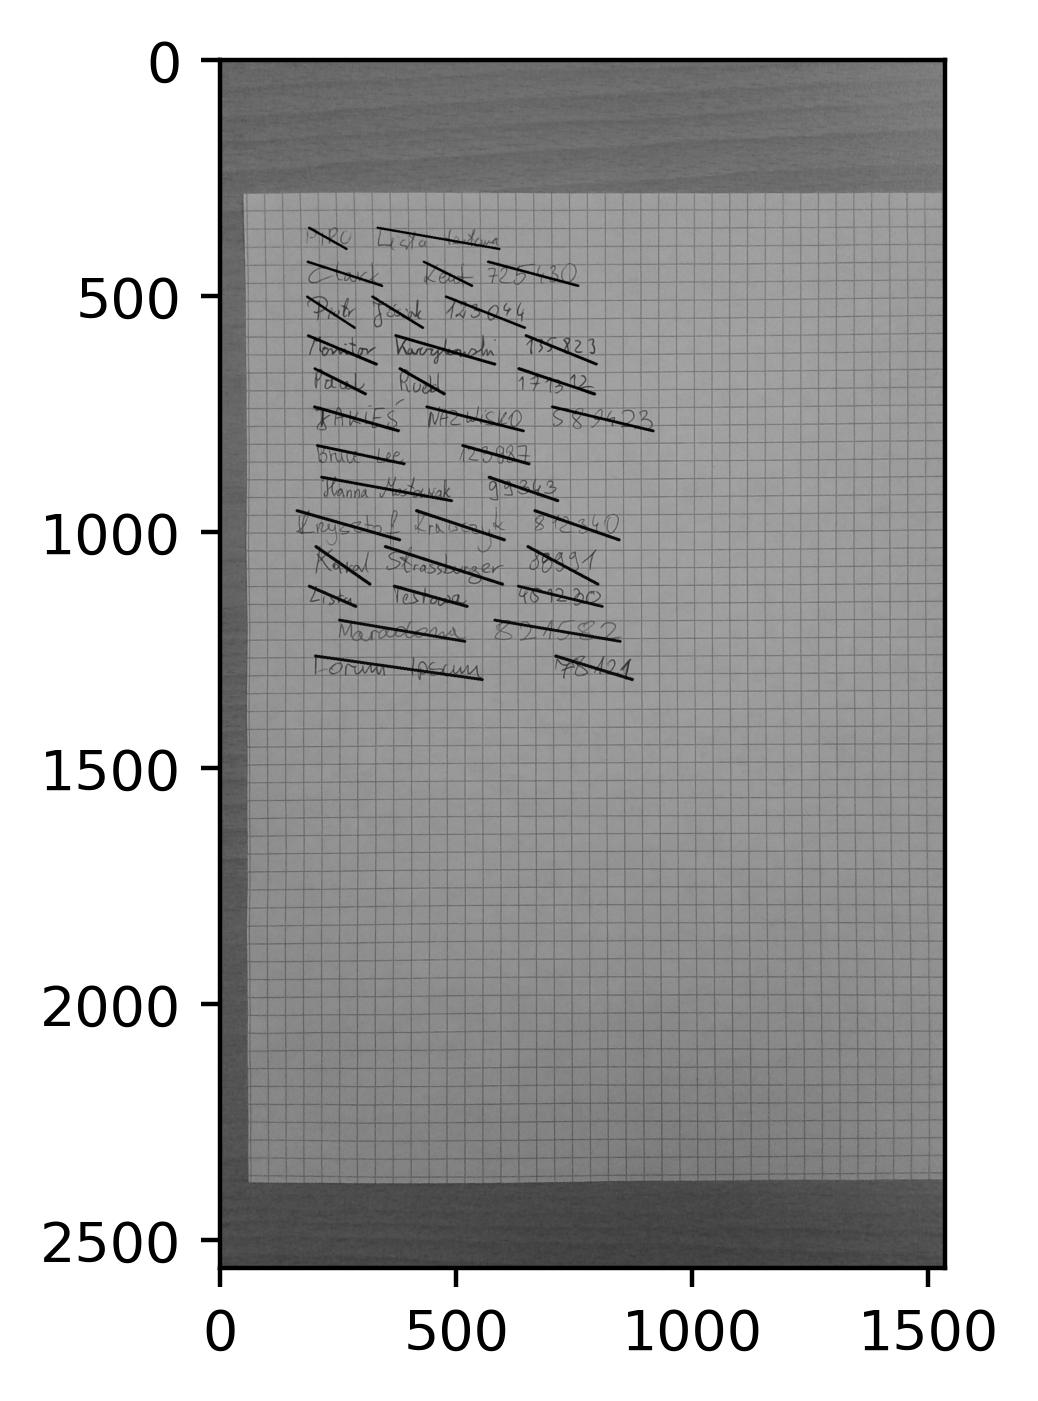

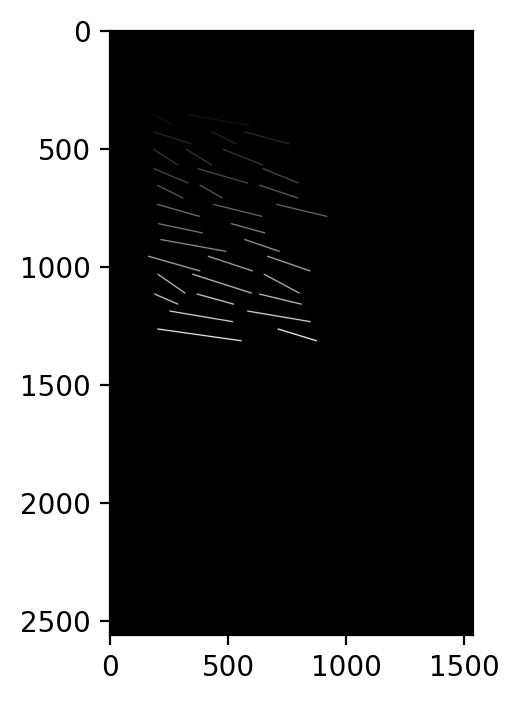

In [80]:
rows_dict, (input_image, _), moments = prepared_rows_per_img[0], input_image_list[0], image_moments[0]
mask = rows_dict['img_segmented']

_, thresh = cv.threshold((mask * 255).astype(np.uint8), 1, 255, cv.THRESH_BINARY)

input_image_bgr = cv.cvtColor(input_image, cv.COLOR_GRAY2BGR)
line_mask = np.zeros(mask.shape, dtype=np.uint8)
for i, row in enumerate(rows):
    for col in row['cols']:
        start_point = (col['from'], row['from'])
        end_point = (col['to'], row['to'])
        line_mask = cv.line(line_mask, start_point, end_point, (i + 1,), 3)

inv_moments = np.linalg.pinv(moments)
warped_mask = cv.warpPerspective(line_mask, inv_moments, (input_image.shape[1], input_image.shape[0]))

mask_bgra = cv.cvtColor(warped_mask, cv.COLOR_GRAY2BGRA)
indexing_mask = (mask_bgra[:, :] == (0, 0, 0, 0)).reshape(mask_bgra.shape)
indexing_mask = np.sum(indexing_mask, axis=2).astype(bool)
mask_bgra[indexing_mask] = (0, 0, 0, 0)

plt.figure(dpi=400)
plt.imshow(input_image_bgr)
plt.imshow(mask_bgra)
plt.show()

plt.figure(dpi=200)
plt.imshow(warped_mask, cmap="gray")
plt.show()

In [ ]:
from src.pipeline_digit_recognition import segment_to_digits, digits_to_mnist_format, load_clf_and_dataset
from src.pipeline_digit_recognition import predict_digits #Import has been split due to auto format issues

import os

for r in rows:
    number = r['cols'][-1]['data']
    plt.imshow(number)
    plt.show()

    digits = segment_to_digits(number)

    #     for d in digits:
    #         plt.imshow(d)
    #         plt.show()

    digits_to_mnist_format(digits)

    #     for d in digits:
    #         plt.imshow(d)
    #         plt.show()

    workdir = os.getcwdb().decode("utf-8")
    clf_pickle_path = workdir + "/pickled_objects/clf_mnist.pickle"
    dataset_pickle_path = workdir + "/pickled_objects/dataset_mnist.pickle"

    clf, _ = load_clf_and_dataset(clf_pickle_path, dataset_pickle_path)

    predict_digits(clf, digits)
